In [1]:
import pandas as pd
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import MultipleLocator
import matplotlib.pyplot as plt
import seaborn as sns  #画密度图
from matplotlib.ticker import MaxNLocator, FuncFormatter, MultipleLocator
import matplotlib.ticker as ticker
import palettable #python颜色库

In [3]:
inpath = '/Users/yanmemgxing/Nutstore Files/scientific group/'

group_info = pd.read_csv(f'{inpath}group_info_OnlyLastAuthorPaper(current_scientific_age1213).csv')
file = 'career_span'
career_span = pd.read_csv(f'{inpath}{file}.csv')
group_info = group_info.merge(career_span[['author_id','career_len']],on='author_id',how='left')
tp = career_span[['author_id','first_pub_year']].rename(columns={'author_id':'mentor_id','first_pub_year':'mentor_first_pub_year'}).drop_duplicates()
group_info = group_info.merge(tp,on='mentor_id',how='left')
mentor_scientific_age = group_info['publication_year'] - group_info['mentor_first_pub_year']
group_info['mentor_scientific_age'] = mentor_scientific_age
mentor_current_scientific_age = group_info['current_year'] - group_info['mentor_first_pub_year']
group_info['mentor_current_scientific_age'] = mentor_current_scientific_age
mentee = list(set(group_info['author_id']))
group_test = group_info[['author_id','mentor_id','institution_id','current_year','career_len',
                         'group_size']][(group_info.current_scientific_age<6)&(group_info.mentor_scientific_age>10)].drop_duplicates()
def group_size_end_year(tp_df):
    # tp_df = tp_df[['author_id','mentor_id','institution_id','current_year','career_len','group_size']].drop_duplicates()
    end_year = round(np.min(tp_df['current_year']))
    career_len = np.mean(tp_df['career_len'])
    group_size = round(np.mean(tp_df['group_size']))
    
    return end_year,career_len,group_size
temp = group_test.groupby(['author_id','mentor_id','institution_id']).apply(group_size_end_year).reset_index(name='group_size_info')
group_size_info = pd.DataFrame(temp.group_size_info.tolist(),columns=['end_year','career_len','group_size'])
temp = pd.concat((temp,group_size_info),axis=1)
average_group_size = temp.groupby(['author_id','end_year','career_len'])['group_size'].agg('mean').reset_index(name='average_group_size')
print(len(average_group_size))
group_info = group_info.merge(average_group_size,on='author_id',how='left')
group_info = group_info.drop(columns=['career_len_x']).rename(columns={'career_len_y':'career_len'})

215296


In [4]:
def random_survial_rate(data,current_year,drop_criteria):
    # data_i = data[data.first_pub_year==current_year]
    temp_i = temp[temp.end_year==current_year]
    group_size_0 = temp_i.group_size.tolist()
    random.shuffle(group_size_0)
    temp_i.loc[:,['random_group_size']] = group_size_0
    average_group_size_i = temp_i.groupby(['author_id','end_year',
                                   'career_len'])['random_group_size'].agg('mean').reset_index(name='average_group_size')
    data_i = average_group_size_i

    Q75 = np.quantile(data_i['average_group_size'],0.75)
    Q50 = np.quantile(data_i['average_group_size'],0.50)
    Q25 = np.quantile(data_i['average_group_size'],0.25)
    Q10 = np.quantile(data_i['average_group_size'],0.10)
    
    #All
    survial_all = data_i[data_i.career_len>=drop_criteria]
    survival_rate_all = len(survial_all)/len(data_i[data_i.career_len>0])
    survival_rate_all_0 = len(survial_all)/len(data_i)
    
    # G75
    G75 = data_i[data_i.average_group_size>=Q75]
    survial_75 = G75[G75.career_len>=drop_criteria]
    survival_rate_75 = len(survial_75)/len(G75[G75.career_len>0])
    survival_rate_75_0 = len(survial_75)/len(G75)
    # print('survival_rate_75,survival_rate_75_0 : ',survival_rate_75,survival_rate_75_0)

    # G25
    G25 = data_i[data_i.average_group_size<=Q25]
    # print('len_G25 : ',len(G25))
    survial_25 = G25[G25.career_len>=drop_criteria]
    # print('len_survival_25 : ',len(survial_25))
    survival_rate_25 = len(survial_25)/len(G25[G25.career_len>0])
    survival_rate_25_0 = len(survial_25)/len(G25)
    # print('survival_rate_25,survival_rate_25_0 : ',survival_rate_25,survival_rate_25_0)
    return len(data_i),len(data_i[data_i.career_len>0]),len(survial_all),survival_rate_all,survival_rate_all_0,survival_rate_75,survival_rate_75_0,survival_rate_25,survival_rate_25_0

In [5]:
data = temp

Data = []
years = list(range(1980,2015+1))
Drop_Criteria = [5,8,10,13]
for drop_criteria in Drop_Criteria:
    for current_year in years:
        # print(drop_criteria,completeness,current_year)

        num_of_mentee,num_of_mentee1,num_of_surviver,survival_rate_all,survival_rate_all_0,survival_rate_75,survival_rate_75_0,survival_rate_25,survival_rate_25_0 = random_survial_rate(data,current_year,drop_criteria)

        temp_ = [current_year,num_of_mentee,num_of_mentee1,num_of_surviver,survival_rate_all,survival_rate_all_0,survival_rate_75,survival_rate_75_0,survival_rate_25,survival_rate_25_0,drop_criteria]
        Data.append(temp_)
        
Data = pd.DataFrame(Data,
                    columns=['current_year','num_of_mentee','num_of_mentee1','num_of_surviver','survival_rate_all',
                    'survival_rate_all_0','survival_rate_75','survival_rate_75_0','survival_rate_25','survival_rate_25_0','drop_criteria'])

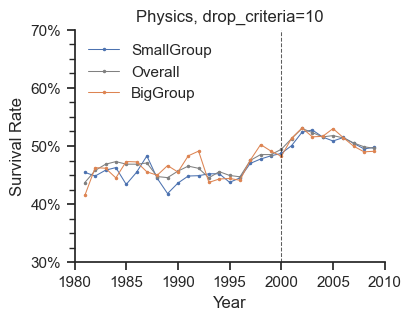

In [6]:
Drop_Criteria = [5,8,10,13,15,18,20]


# input parameter
drop_criteria = 10

df = Data[(Data.drop_criteria==drop_criteria)&(Data.current_year<=2009)&(Data.current_year>=1979)].sort_values(by='current_year')


sns.set(style='ticks', font_scale=1.0, font='Arial')
fig, ax = plt.subplots(constrained_layout=True,figsize=[1*4,0.618*5])

# data
x = list(df.current_year)
y_small = [float(k) for k in list(df.survival_rate_25.rolling(2).mean())]
y_all = [float(k) for k in list(df.survival_rate_all.rolling(2).mean())]
y_big = [float(k) for k in list(df.survival_rate_75.rolling(2).mean())]

# plot
ax.plot(x, y_small, label=f'SmallGroup', marker='.',ms=3,lw=0.75)
ax.plot(x, y_all, label=f'Overall', marker='.',color='grey',ms=3,lw=0.75)
ax.plot(x, y_big, label=f'BigGroup', marker='.',ms=3,lw=0.75)

# annotation set
ax.legend(frameon=0)
# ax.legend(loc=2,frameon=0)
ax.set(xlim=(x[0], 2010),#|xticks=np.arange(x[0]-1, x[-1]+5,5),
       ylim=(0.3, 0.7),# yticks=np.arange(0.3, 0.71, 0.1),
       xlabel='Year', 
       ylabel='Survival Rate',
       title=f'Physics, drop_criteria={drop_criteria}'
      )
ax.set_xticks(ticks=np.arange(1980, 2015,5),labels=np.arange(1980, 2015,5),rotation=0)
ax.set_yticks(ticks=[0.3,0.4,0.5,0.6,0.7],labels=['30%','40%','50%','60%','70%'])
# ax.axvline(x=2022-3-drop_criteria,ls='--',color='r',lw=0.75)
ax.axvline(x=2000,ls='--',color='k',alpha=0.7,lw=0.75)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)

# ax.xaxis.set_major_locator(MultipleLocator(5))
# ax.xaxis.set_minor_locator(MultipleLocator(1))

# ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.yaxis.set_minor_locator(MultipleLocator(0.025))

# ax.annotate('Accurate Line', xy=(2022-3-drop_criteria, 0.5), xytext=(2022-3-drop_criteria, 0.56),
#             arrowprops=dict(facecolor='r', shrink=0.05,edgecolor='r'),fontsize=10)
plt.show()
fig.savefig(f'robustness test/random_survival_rate(drop_criteria={drop_criteria}).pdf')